In [5]:
import os
import sys
import random
import pandas as pd
import numpy as np
from scipy.linalg import toeplitz
from copy import copy
import matplotlib.pyplot as plt
%matplotlib inline

# Geniuses that worked on hypertools did not update certain package and thus it produces warnings (they break jupyter lab)
import warnings
warnings.filterwarnings("ignore")

# Comment out if you don't want to see all of the values being printed (i.e. default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

current_dir = os.getcwd()
# utils_path = os.path.join(current_dir, '..', 'utils')
utils_path = os.path.join(current_dir, '../')
utils_abs_path = os.path.abspath(utils_path)
if utils_abs_path not in sys.path:
    sys.path.append(utils_abs_path)

import utils.get_data as get_data
# from impute_methods import *
from utils.impute_methods import impute_linear_interpolation

DATA_PATH = get_data.get_dataset_abspath()

training_setA_path = DATA_PATH + 'training_setA'
training_setB_path = DATA_PATH + 'training_setB'

In [ ]:
def plot_heart_rate_data(df):
    plt.figure(figsize=(10, 6))
    dataset['HR'].hist(bins=50)
    plt.title('Distribution of Heart Rate')
    plt.xlabel('Heart Rate')
    plt.ylabel('Frequency')
    plt.show()
    
    # You can also get a quick statistical summary
    print(dataset['HR'].describe())
    

   20336
   40336
Putting data into dataframe...
Done
Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')


<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Distribution of Heart Rate')

Text(0.5, 0, 'Heart Rate')

Text(0, 0.5, 'Frequency')

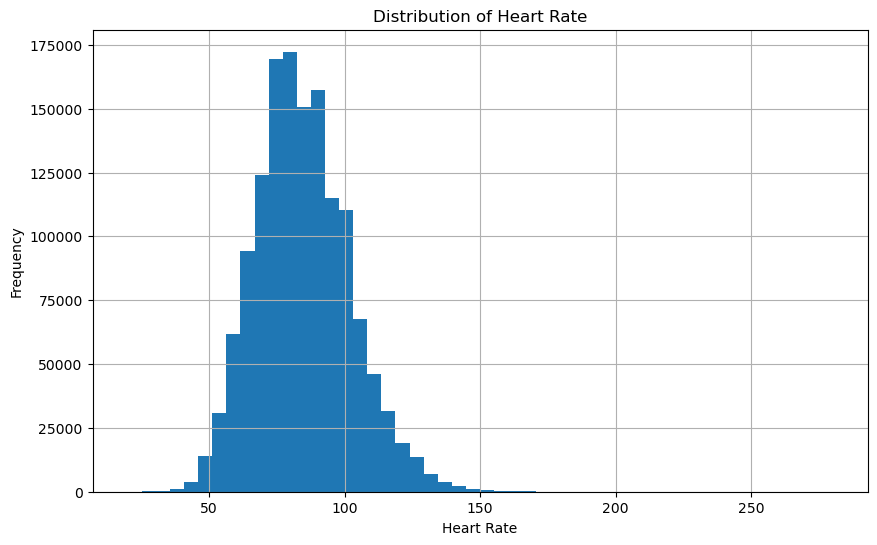

count    1.398811e+06
mean     8.458144e+01
std      1.732524e+01
min      2.000000e+01
25%      7.200000e+01
50%      8.350000e+01
75%      9.550000e+01
max      2.800000e+02
Name: HR, dtype: float64


In [6]:
# DATA PREPROCESSING

# Fill in some data that is easily imputed
dataset = get_data.get_dataset_as_df()

# Imputes Heart Rate using linear interpolation
dataset = impute_linear_interpolation(dataset, 'HR')
print("Finished imputing Heart Rate")

# Imputes O2Sat using linear interpolation
# Other methods might be better based on the data distribution (consider Spline or Polynomial Interpolation)
dataset = impute_linear_interpolation(dataset, 'O2Sat')
print("Finished imputing O2Sat")

# Impute SBP using linear interpolation
# We can consider Forward Fill or Backward Fill if we assume the blood pressure should remain relatively stable
dataset = impute_linear_interpolation(dataset, 'SBP')
print("Finished imputing SBP")

# Impute MAP using linear interpolation
# To be more sophiscticated the data can be imputed with custom models to take into account SBP and DBP as there might be correlation
dataset = impute_linear_interpolation(dataset, 'MAP')
print("Finished imputing MAP")

# Impute DBP using linear interpolation
# Same as SBP, we might consider Spline
dataset = impute_linear_interpolation(dataset, 'DBP')
print("Finished imputing DBP")

# Impute Resp using linear interpolation
# Same as SBP and DBP, we might consider Spline or Polynomial Interpolation
dataset = impute_linear_interpolation(dataset, 'Resp')
print("Finished imputing Resp")


# Use forward filling for some of the data

# Best solution used sliding window

# Extract features for each patient data individually
def extract_features(patient_data):
    # Get the column with Sepsis Label as it is not the same for each row (check documentation)
    label = np.array(patient_data['SepsisLabel'])
    patient_data = patient_data.drop(columns=['SepsisLabel'])

    # some code
    # Forward-Filling missing values
    data = data.fillna(method='ffill')
    
    return features, labels

# Run feature extraction for each patient
